# Assignment 2: Experimentation & Model Training
Authors: Naomi Buell and Richie Rivera

## EDA Recap

### Load Libraries and Dataset

First, we import libraries and load the Portuguese banking dataset.

In [33]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, recall_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import plot_tree

import numpy as np
import zipfile
import io
import requests

import seaborn as sns

In [3]:
# Download the zip file from the internet
url = "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"
response = requests.get(url)

# Extract bank-additional.zip from the downloaded zip
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open('bank-additional.zip') as additional_zip_file:
        with zipfile.ZipFile(additional_zip_file) as additional_zip:
            # Extract bank-additional-full.csv from bank-additional.zip
            with additional_zip.open('bank-additional/bank-additional-full.csv') as csvfile:
                df = pd.read_csv(csvfile, sep=';')

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Handle Missing Values

There are some observations set as "unknown" in several categorical columns. Additionally, the `pdays` column has a value of 999 which means the client was not previously contacted. We will treat these as missing values.

In [4]:
# Check for categorical variables that are "unknown" and replace 'unknown' with np.nan in all object (categorical) columns
df_nas = df.copy()
df_nas = df_nas.replace('unknown', np.nan)
df_nas = df_nas.replace(999, np.nan)  # Replace 999 in 'pdays' with np.nan

# Check for categorical variables that are now NA
na_counts = df_nas.isna().sum()
na_counts = na_counts[na_counts > 0].sort_values(ascending=False)
na_perc = (na_counts / len(df_nas)) * 100
print("Columns with NA values and their % missing:")
print(na_perc.round(2))

Columns with NA values and their % missing:
pdays        96.32
default      20.87
education     4.20
housing       2.40
loan          2.40
job           0.80
marital       0.19
duration      0.00
dtype: float64


`pdays` is now 96% missing in cases where the client has not been previously contacted. `default` (whether or not the client has credit in default) has significant missingness. `education` (education level), `housing` (whether the client has a housing loan), `loan` (whether the client has a personal loan), `job` (type of job), and `marital` (marital status) have some minor missingness. We will address this missingness next.



We drop `default`, whether the client has credit in default, since it is 21% missing and there is little risk of losing valuable information that our classifier needs to discriminate between classes (most clients with known data are not in default. 79% no, <1% yes, 20% unknown). We also drop `pdays` (number of days that passed by after the client was last contacted from a previous campaign) since it is 96% missing and was determined to be not useful for prediction according to the IV. For the other columns with minor missingness (`education`, `housing`, `loan`, `job`, and `marital`), we will drop rows with missing data. Since the missingness is low, we will not lose much information by dropping these rows. We also drop the `duration` column, the last contact duration in seconds, because this attribute highly affects the output target (e.g., if duration=0 then y="no"). Per the bank data notes, this input should be discarded for our predictive model.

In [5]:
# Save a new dataframe for preprocessing
df_dropped = df_nas.copy()

# Remove `default` and `pdays` columns due to high missingness. Drop duration per data notes.
df_dropped = df_dropped.drop(columns=['default', 'pdays', 'duration'])

# Drop rows with missing values in other columns
df_dropped = df_dropped.dropna()

# Display ns before and after dropping missing values
print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_dropped.shape}")

Original dataset shape: (41188, 21)
Cleaned dataset shape: (38245, 18)


### Handling Duplicate rows

In [6]:
df_duplicates = df_dropped[df_dropped.duplicated()]

print(f"There are {df_duplicates.shape[0]:,} duplicate entries\nThis is {100*round(df_duplicates.shape[0]/df_dropped.shape[0],3)}% of the total")

There are 1,946 duplicate entries
This is 5.1% of the total


We can handle these duplicates by dropping them.

In [7]:
df_deduped = df_dropped.drop_duplicates()

print(f"Number of remaining entries: {df_deduped.shape[0]:,}")

Number of remaining entries: 36,299


After dropping the duplicates, we still have sufficient data to run a decision tree, random forest, and AdaBoost model with, even after removing rows with missing values. 

### Handle Categorical Features

Next, we map ordinal categorical variables to numeric values. In this case, we map the education levels to estimated number of years of schooling. We also map the days of the week and months to their respective orderings.

In [8]:
df_fe = df_dropped.copy()

# Map education levels to numeric values
education_mapping = {
    'illiterate': 0,                # 0 years
    'basic.4y': 4,                  # 4 years
    'basic.6y': 6,                  # 6 years
    'basic.9y': 9,                  # 9 years
    'high.school': 12,              # 12 years (typical for high school)
    'professional.course': 14,      # 14 years (post-secondary/professional)
    'university.degree': 16         # 16 years (bachelor's degree)
}
df_fe['education'] = df_fe['education'].map(education_mapping)

# Encode month as integer
month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
             'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
df_fe['month'] = df_fe['month'].map(month_map)

# Encode day as integer
day_map = {'sun': 1, 'mon': 2, 'tue': 3, 'wed': 4, 'thu': 5, 'fri': 6, 'sat': 7}
df_fe['day_of_week'] = df_fe['day_of_week'].map(day_map)

We also perform label encoding on other categorical variables before we feed data to tree-based machine learning algorithms.

In [9]:
# One-hot encode nominal categorical variables
df_dummies = df_fe.copy()
df_dummies = pd.get_dummies(df_dummies, columns=['job', 'marital', 'housing', 'loan', 'contact', 'poutcome', 'y'], drop_first=True)
df_dummies = df_dummies.rename(columns={'y_yes': 'y'})

df_dummies.head()

,age,education,month,day_of_week,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,job_technician,job_unemployed,marital_married,marital_single,housing_yes,loan_yes,contact_telephone,poutcome_nonexistent,poutcome_success,y
0,56,4,5,2,1,0,1.1,93.994,-36.4,4.857,...,False,False,True,False,False,False,True,True,False,False
1,57,12,5,2,1,0,1.1,93.994,-36.4,4.857,...,False,False,True,False,False,False,True,True,False,False
2,37,12,5,2,1,0,1.1,93.994,-36.4,4.857,...,False,False,True,False,True,False,True,True,False,False
3,40,6,5,2,1,0,1.1,93.994,-36.4,4.857,...,False,False,True,False,False,False,True,True,False,False
4,56,12,5,2,1,0,1.1,93.994,-36.4,4.857,...,False,False,True,False,False,True,True,True,False,False


We can now move onto the model training and experimentation section.

> Noting that since tree-based models do not need standardization, PCA, or data balancing, we did not include this step in our EDA, even though we did perform it in our previous assignment.

## Decision Trees

### Experiment 1

**Objective**: To determine which is a more accurate pruning technique--a max depth of 2 or of 4--in a decision tree model predicting customers' decision to subscribe to the bank's term deposit.

**Variation tested**: Decision tree with max depth of 4, using all features, split 70% training and 30% testing.

**Evaluation metric**: Classification accuracy in terms of the fraction of correctly classified samples, using `accuracy_score` from `sklearn.metrics`. We calculate accuracy for both training and test sets.

**Test**: 

In [10]:
# Separate features and target
X = df_dummies.drop(columns=['y'])
y = df_dummies['y']

# Randomly split the X and y arrays into 30 percent test data and 70 percent training data.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

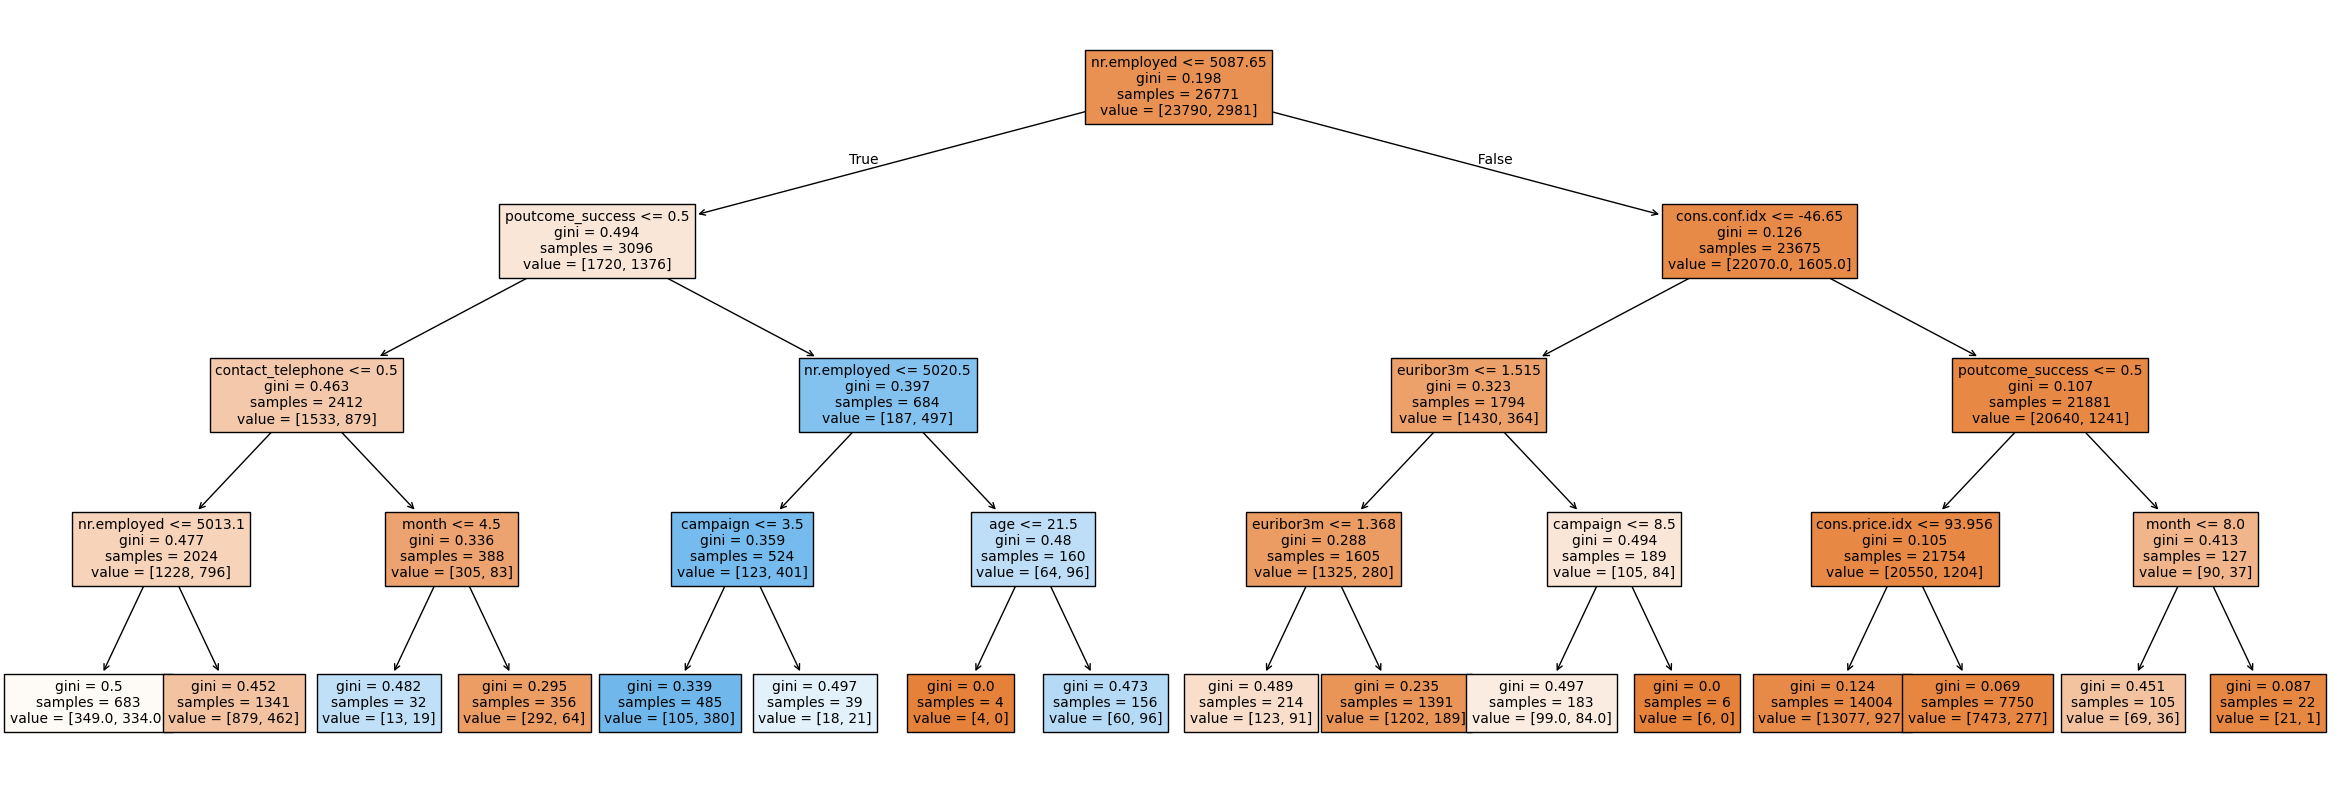

In [11]:
# Create and fit a decision tree model
tree_model_1 = DecisionTreeClassifier(criterion='gini',
                                     max_depth=4,
                                     random_state=1)
tree_model_1.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plt.figure(figsize=(30, 10))
tree.plot_tree(tree_model_1, filled=True, feature_names=list(X.columns), fontsize=10)
plt.show()

**Result**:

In [12]:
# Accuracy on training set
y_train_pred = tree_model_1.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print('Training Accuracy: %.2f%%' % (train_acc * 100))

# Accuracy on test set
y_test_pred = tree_model_1.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print('Test Accuracy: %.2f%%' % (test_acc * 100))

Training Accuracy: 90.06%
Test Accuracy: 89.95%


**Recommendation**: The decision tree model with a max depth of 4 and split into 70% training/30% testing was **89.95%** accurate on the test data. There is no sign of overfitting (or variance) as the training accuracy is similar at 90.06%.

The first split is based on the number of employees (`nr.employed`), indicating it's the most important feature for predicting subscription. When `nr.employed` > 5087.65, we get fewer subscriptions (2,981 yes out of 26,771 total). This means that when the economy is strong (employment is high), people are less likely to invest in term deposits (perhaps because they have more attractive financial options). Conversely, during weaker employment periods, term deposits become more appealing as a safe investment. **The bank can aim to focus marketing efforts during times of lower employment to potentially increase subscription rates.**

We can further experiment with post-pruning to optimize accuracy.

### Experiment 2

**Objective**: To determine which is a more accurate pruning technique--a max depth of 2 or of 4--in a decision tree model predicting customers' decision to subscribe to the bank's term deposit.

**Variation tested**: Same as above, but pruned to have a max depth of 2.

**Evaluation metric**: Accuracy.

**Test**: 

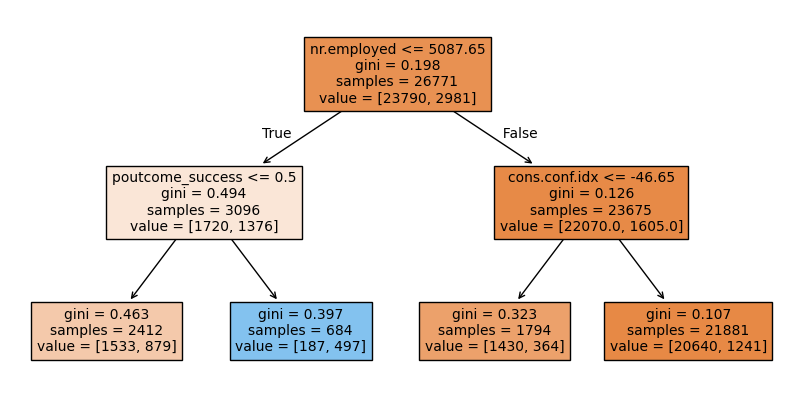

In [13]:
# Create and fit a decision tree model
tree_model_2 = DecisionTreeClassifier(criterion='gini',
                                     max_depth=2, # Decrease max depth to 2
                                     random_state=1)
tree_model_2.fit(X_train, y_train)

plt.figure(figsize=(10, 5))
tree.plot_tree(tree_model_2, filled=True, feature_names=list(X.columns), fontsize=10)
plt.show()

**Result**:

In [14]:
# Accuracy on training set
y_train_pred = tree_model_2.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print('Training Accuracy: %.2f%%' % (train_acc * 100))

# Accuracy on test set
y_test_pred = tree_model_2.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print('Test Accuracy: %.2f%%' % (test_acc * 100))

Training Accuracy: 90.02%
Test Accuracy: 89.96%


**Recommendation**: The decision tree model with a max depth of 2 was **89.96%** accurate, which is an **improvement from the prior model in Experiment 1**. There is no sign of overfitting as the training accuracy is similar at 90.02%.

The first splits are based on the same variables and thresholds as before, where the employment levels are the most important feature for predicting subscription. This further supports the recommendation for the bank to focus marketing efforts during times of lower employment.

When employement is low, the next strongest predictor is past marketing success (`poutcome_success`). Clients who succeeded in a previous campaign (`poutcome_success` > 0.5) have a much higher chance of subscribing again: 73% (187 no, 497 yes) subscription rate in the peach-colored left node vs. 36% (1533 no, 879 yes) subscription rate in the blue right node. **The bank should focus marketing efforts on clients who responded positively in prior campaigns since they are about 2× more likely to subscribe again.**

When employment is high, the next best predictor is the consumer confidence index (`cons.conf.idx`). If confidence is low (≤ -46.65), subscription likelihood is about 20.3% (1,430 no vs. 364 yes in light orange leaf). When confidence is high (> -46.65), subscription drops sharply to abou 5.7% (20,640 no vs. 1,241 yes). This indivates that the **bank should avoid heavy marketing during times of high consumer confidence and strong employment** when people are less interested in low-risk investments like term deposits then.

## Random Forest

### Experiment 1

**Objective**: To determine whether using 25 trees or a grid search more accurately predicts customers' decisions to subscribe to the bank's term deposit in a random forest model.

**Variation tested**: Random forest with 25 trees, split 70% training and 30% testing.

**Evaluation metric**: Accuracy and recall. 

**Test**: 

In [15]:
# Generate RF model
forest_1 = RandomForestClassifier(n_estimators=25,
                                random_state=1,
                                n_jobs=2)
forest_1.fit(X_train, y_train)


,n_estimators,25
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


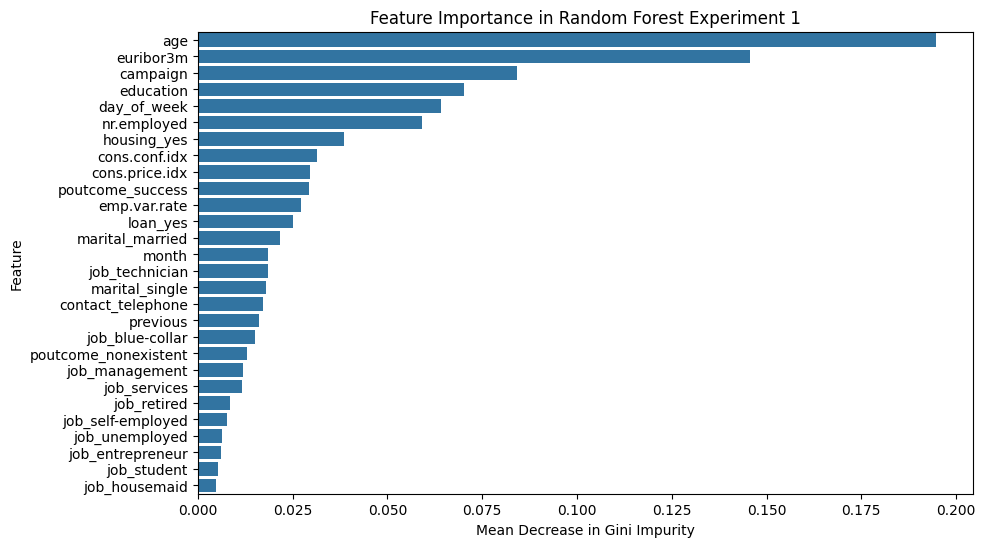

In [30]:
# Get feature importances
importances = pd.Series(forest_1.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance in Random Forest Experiment 1")
plt.xlabel("Mean Decrease in Gini Impurity")
plt.ylabel("Feature")
plt.show()

**Result**:

In [28]:
# Accuracy on training set
y_train_pred = forest_1.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print('Training Accuracy: %.2f%%' % (train_acc * 100))

# Accuracy on test set
y_test_pred = forest_1.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print('Test Accuracy: %.2f%%' % (test_acc * 100))

# Calculate final recall on the test set
test_recall_rf1 = recall_score(y_test, y_test_pred)
print('Model Recall on Test Set:  %.2f%%' % (test_recall_rf1 * 100))

Training Accuracy: 99.14%
Test Accuracy: 89.38%
Model Recall on Test Set:  30.15%


**Recommendation**: This random forest model is the least accurate so far, at **89.36%** accuracy in correctly predicting a subscriber. However, since the training accuracy is very high at 99.15% (nearly a perfect fit to the training data!), **this may indicate overfitting**. 

The recall of the model is very poor. It is only correctly identifying **30.15%** of true positives (subscribers). This is likely due to the significant class imbalance in the dataset, where only about 12% of clients subscribed to a term deposit. The model is biased towards predicting the majority class (non-subscribers), potentially leading to low recall for the minority class (subscribers).

Age is the most important predictor in this model, followed by `euribor3m`, a daily indicator of the 3-month Euribor (Euro Interbank Offered Rate). The number of contacts performed during this campaign and for a particular client is the third most important predictor. 

This suggests that subscription likelihood varies by customer age and is sensitive to broader economic conditions reflected in the Euribor rate. When interest rates are lower, customers may be more receptive to long-term deposits. Therefore, the bank could prioritize outreach to age groups historically more responsive (e.g., clients 55 plus, as found in our prior report) during favorable economic periods. Additionally, optimizing the number of contacts (rather than contacting clients indiscriminately) may improve subscription rates and reduce customer fatigue.

We can continue to experiment with hyperparameters to reduce overfitting.

### Experiment 2

**Objective**: To determine whether using 25 trees or a grid search more accurately predicts customers' decisions to subscribe to the bank's term deposit in a random forest model.

**Variation tested**: Random forest with grid search over number of trees (10-50, in increments of 5) and max depth (2-6 and None, in increments of 1) using 5 fold cross validation, split 70% training and 30% testing.

**Evaluation metric**: Accuracy and recall.

**Test**: 

In [18]:
# Set up our parameters for grid search
param_grid = {
    'n_estimators': [10, 15, 20, 25, 30, 35, 40, 45, 50],
    'max_depth': [2, 3, 4, 5, 6, None]
}

# Initialize our random forest classifier
forest_2 = RandomForestClassifier(random_state=1)

# Set up the grid search with recall as the scoring metric
grid_search = GridSearchCV(
    estimator=forest_2,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1 # This allows us to use all available cores to speed up the training
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best Hyperparameters: {grid_search.best_params_}")

Best Hyperparameters: {'max_depth': None, 'n_estimators': 15}


In [ ]:
# Get the best model from the grid search
best_forest = grid_search.best_estimator_

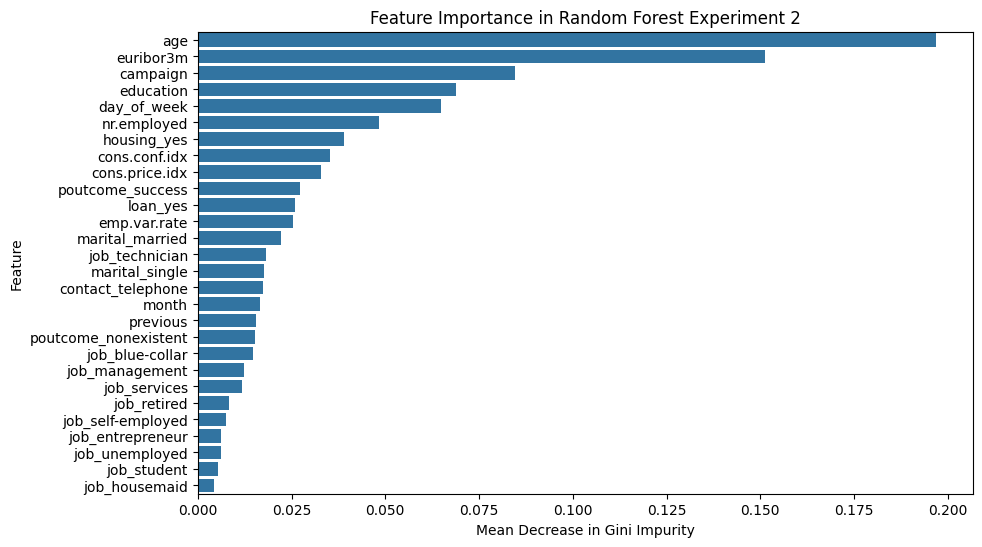

In [31]:
# Get feature importances
importances = pd.Series(best_forest.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance in Random Forest Experiment 2")
plt.xlabel("Mean Decrease in Gini Impurity")
plt.ylabel("Feature")
plt.show()


In [ ]:
# Accuracy on training set
y_train_pred = best_forest.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print('Training Accuracy: %.2f%%' % (train_acc * 100))

# Accuracy on test set
y_pred_best_forest = best_forest.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_best_forest)
print('Test Accuracy: %.2f%%' % (test_acc * 100))

# Calculate final recall on the test set
test_recall_rf2 = recall_score(y_test, y_pred_best_forest)
print('Final Model Recall on Test Set:  %.2f%%' % (test_recall_rf2 * 100))

# Display a more detailed classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_best_forest))

Training Accuracy: 98.79%
Test Accuracy: 89.02%
Final Model Recall on Test Set:  30.46%

Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.92      0.96      0.94     10197
        True       0.51      0.30      0.38      1277

    accuracy                           0.89     11474
   macro avg       0.71      0.63      0.66     11474
weighted avg       0.87      0.89      0.88     11474



**Result**: This random forest model is even less accurate than the prior random forest, at **89.02%** accuracy in correctly predicting a subscriber. Additionally, since the training accuracy is very high at 98.79% (nearly a perfect fit to the training data!), **this one also shows signs of overfitting**. 

The recall of the model is still very poor. It is only correctly identifying **30.46%** of true positives (subscribers), which is a slight improvement from the prior model. This is likely due to the significant class imbalance in the dataset, where only about 12% of clients subscribed to a term deposit. The model is biased towards predicting the majority class (non-subscribers), potentially leading to low recall for the minority class (subscribers).

The most important features in this model are similar to the prior random forest, with age again being the top predictor, followed by `euribor3m` and number of contacts during this campaign.

**Recommendation**: Although we found an optimal model for recall using grid search, **we are not able to use this model** in production as it is only able to correctly predict a small number of customers who signed up for term deposit. If the bank desires to use this model to predict future term deposits then this model is not sufficient. To improve recall, we recommend to undersample the majority class to address the imbalance or to employ SMOTE in order to balance the dataset better.

## Adaboost

### Experiment 1

**Objective**: To find the optimal algorithm hyperparameters to improve model recall with an AdaBoost classifier.

**Variation tested**: Adaboost with 50 estimators and learning rate of 1, split 70% training and 30% testing.

**Evaluation metric**: Recall

**Test**: 

In [20]:
# train the adaboost algorithm
adaboost_1 = AdaBoostClassifier(
    n_estimators=50,
    learning_rate=1,
    random_state=1
)

# Train our model
adaboost_1.fit(X_train, y_train)

,estimator,None
,n_estimators,50
,learning_rate,1
,algorithm,'deprecated'
,random_state,1


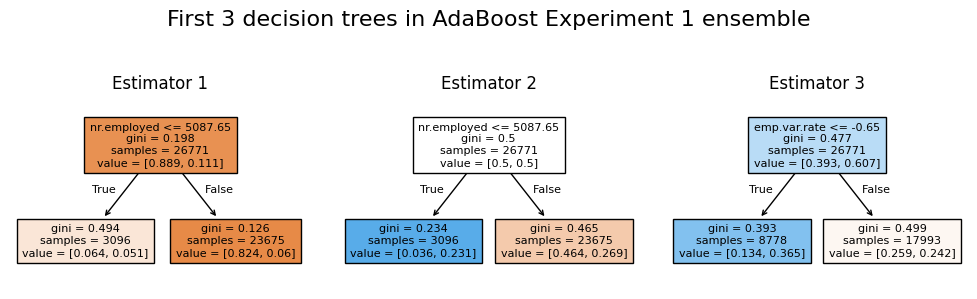

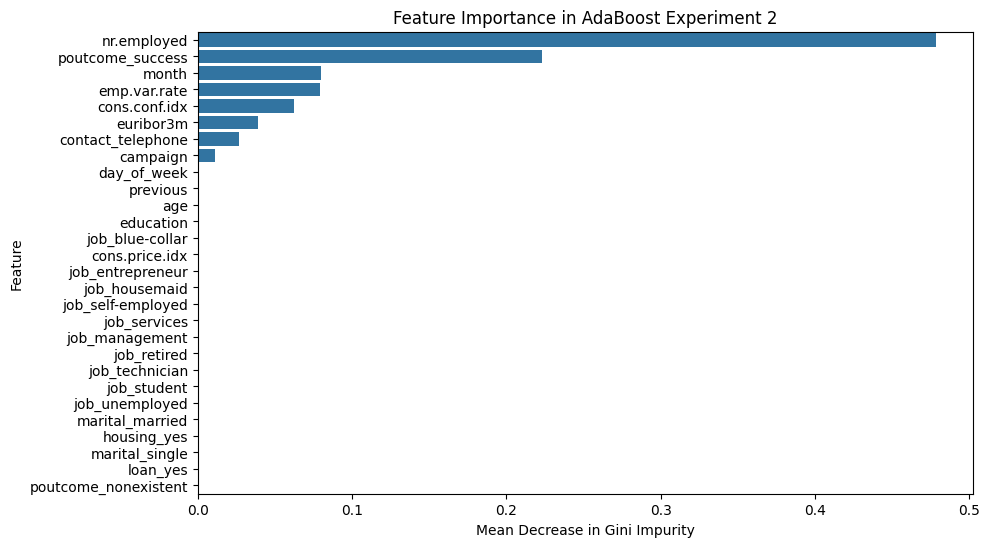

In [48]:
plt.figure(figsize=(10, 3))
plt.suptitle("First 3 decision trees in AdaBoost Experiment 1 ensemble", fontsize=16)
for i, estimator in enumerate(adaboost_1.estimators_[:3]):  # Show first 3 trees for clarity
    plt.subplot(1, 3, i + 1)
    plot_tree(estimator, feature_names=X_train.columns, filled=True, fontsize=8)
    plt.title(f'Estimator {i+1}')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

importances = pd.Series(adaboost_1.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance in AdaBoost Experiment 2")
plt.xlabel("Mean Decrease in Gini Impurity")
plt.ylabel("Feature")
plt.show()

In [42]:
# Get our predictions
y_pred_ada_1 = adaboost_1.predict(X_test)

# Calculate final recall on the test set
test_recall_ada1 = recall_score(y_test, y_pred_ada_1)
print('Final Model Recall on Test Set:  %.2f%%' % (test_recall_ada1 * 100))

# Display a more detailed classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_ada_1))

Final Model Recall on Test Set:  17.38%

Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.91      0.99      0.95     10197
        True       0.70      0.17      0.28      1277

    accuracy                           0.90     11474
   macro avg       0.80      0.58      0.61     11474
weighted avg       0.88      0.90      0.87     11474



**Result**: The AdaBoost model, configured with 50 estimators and a learning rate of 1, achieved a final recall of **0.1738** on the test set. This really low score means that the model is failing to identify about **83%** of actual customers with subscriptions. Desptie this, the model showed high precision meaning that there's a strong chance that any customer predicted to subscribe actually does so. Again, the high accuracy of 90% is misleading due to the imbalanced dataset.

The plot of the first 3 decision trees in the ensemble shows that the model is classifying the data focusing on employment-related indicators `emp.var.rate` and `nr.employed`, suggesting that these economic indicators are key factors in customers' decisions to subscribe to term deposits. The plot of important features confirms that economic indicators appear in the top predictors.

**Recommendation**: This model isn't good for its goal of maximizing recall. A comprehensive grid search should be performed to optimize hyperparameters to potentially improve recall. Additionally, techniques to handle the class imbalance, such as using SMOTE on the training data, should be explored to help the model better learn the patterns of the minority class.

### Experiment 2

**Objective**: To improve recall by tuning hyperparameters using grid search and by balancing the dataset by undersampling the majority class in order to improve recall of an AdaBoost classifier.

**Variation tested**: A resampled dataset to balance the dataset and an optimized Adaboost model using a range of estimators (20-300 in increments of 25) and learning rates (0-1 in increments of 0.05) using 5-fold cross validation, split 70% training and 30% testing.

**Evaluation metric**: Recall

**Test**: 

In [22]:
# Firstly, we will balance the dataset by undersampling the majority class
undersampler = RandomUnderSampler(random_state=1)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

print(f"Resample training set size: {X_train_resampled.shape[0]:,}")

Resample training set size: 5,962


In [23]:
# Now we'll set up our grid search
param_grid = {
    'n_estimators': list(range(20, 301, 25)),
    'learning_rate': [round(x, 2) for x in np.arange(0.1, 1.01, 0.05)],
}

# Creating our AdaBoost classifier
ada_boost_2 = AdaBoostClassifier(random_state=1)

grid_search_ada = GridSearchCV(
    estimator=ada_boost_2,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1 # With our wide range of hyperparameters, we're going to need to use all available cores to speed up the training
)

# Run the grid search on the resampled training data
grid_search_ada.fit(X_train_resampled, y_train_resampled)


,estimator,AdaBoostClass...andom_state=1)
,param_grid,"{'learning_rate': [np.float64(0.1), np.float64(0.15), ...], 'n_estimators': [20, 45, ...]}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,estimator,None


In [43]:
print(f"Best Hyperparameters Found: {grid_search_ada.best_params_}")
print('Best Cross-Validation Recall Score:  %.2f%%' % (grid_search_ada.best_score_ * 100))


best_ada = grid_search_ada.best_estimator_
y_pred_ada2 = best_ada.predict(X_test)

print(classification_report(y_test, y_pred_ada2))

Best Hyperparameters Found: {'learning_rate': np.float64(0.85), 'n_estimators': 20}
Best Cross-Validation Recall Score:  70.24%
              precision    recall  f1-score   support

       False       0.95      0.74      0.83     10197
        True       0.25      0.70      0.37      1277

    accuracy                           0.73     11474
   macro avg       0.60      0.72      0.60     11474
weighted avg       0.87      0.73      0.78     11474



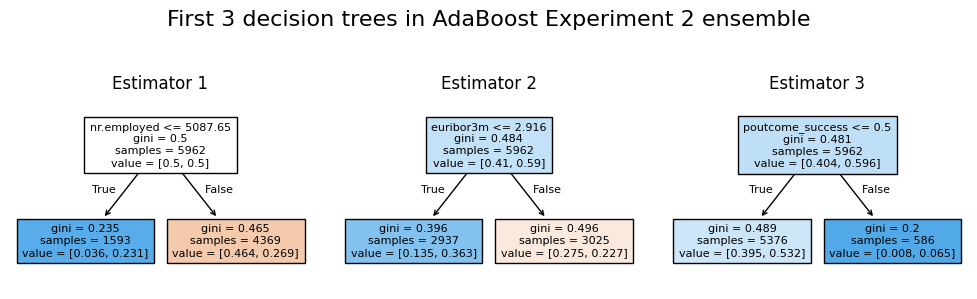

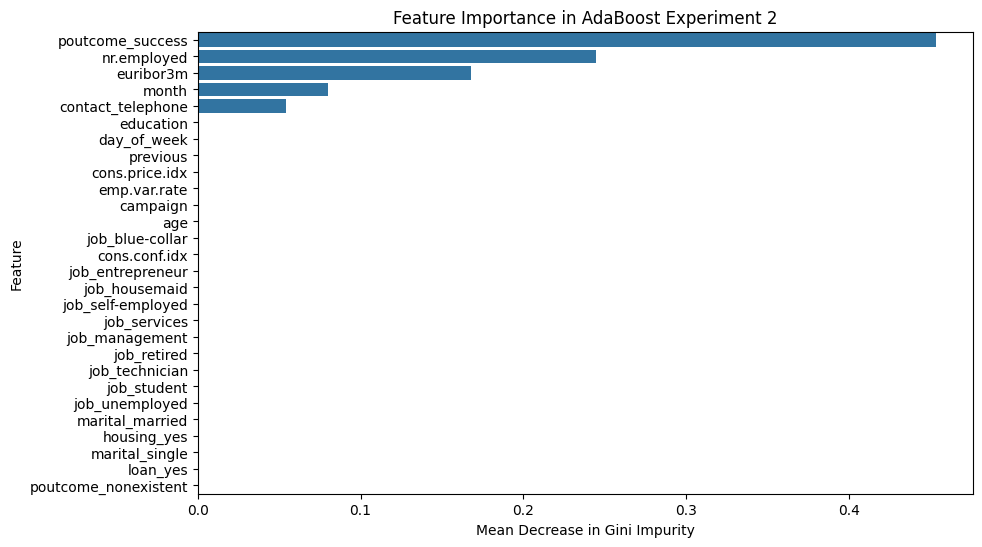

In [49]:
# Plot the first 3 trees from the best AdaBoost model
plt.figure(figsize=(10, 3))
plt.suptitle("First 3 decision trees in AdaBoost Experiment 2 ensemble", fontsize=16)
for i, estimator in enumerate(best_ada.estimators_[:3]):
    plt.subplot(1, 3, i + 1)
    plot_tree(estimator, feature_names=X_train.columns, filled=True, fontsize=8)
    plt.title(f'Estimator {i+1}')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

importances = pd.Series(best_ada.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance in AdaBoost Experiment 2")
plt.xlabel("Mean Decrease in Gini Impurity")
plt.ylabel("Feature")
plt.show()

**Result**: From our grid search, our optimal model has a learning rate of 0.85 and 20 estimators. This method seems to be highly effective as we have a high recall indicating that we are able to correctly identify **70.24%** of actual subscribers. However, the precision is quite low at 0.25 meaning that many of our predictions are false positives. Despite this, we still have a fairly good accuracy of 73%. 

The plot of the first 3 decision trees show more balanced splits between classes (see the `value` labels), indicating that the model is better able to distinguish between subscribers and non-subscribers after balancing the dataset. The estimators split on a variety of features, both economic (`nr.employed`, `euribor3m`) and otherwise (`poutcome_success`, the outcome of the previous marketing campaign), suggesting that multiple factors can influence subscription likelihood. 

The plot of important features shows that the outcome of the previous marketing campaign (`poutcome_success`) is the most important feature, followed by economic indicators `nr.employed` and `euribor3m`. The bank should focus marketing efforts on clients who responded positively in prior campaigns and focus efforts during economic periods where customers are more likely to subscribe. Certain months indicate seasonality plays a role, so the bank could consider timing campaigns accordingly. Additionally, the bank should aim to contact people via their telephone (as opposed to cell phone) since this is also an important feature.

**Recommendation**: In terms of the objective of increasing recall, this model performs well as it has the highest recall of any model trained where recall was investigated. That being said, the low precision means that many of the customers predicted to subscribe actually do not. If the bank is okay with this tradeoff, then this model can be used in production. However, if the bank wants to improve precision, then further hyperparameter tuning and data balancing techniques should be explored.

## Conclusion
We determined that the AdaBoost model with hyperparameter tuning and data balancing provided the best recall performance, correctly identifying over 70% of actual subscribers. However, this came at the cost of low precision, indicating many false positives.